Before start, may need

    !pip install -U unidecode
    !pip install --upgrade pip
    !pip install tweepy
    !pip install wordcloud
    !pip install plotly

In [3]:
import tweepy
import pandas as pd
import numpy as np
from time import sleep
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt 
%matplotlib inline

# Connect to Tweeter API and collect tweets

In [98]:
access_token = ''
access_token_secret = ''
consumer_key = ''
consumer_secret = ''

                    # AppAuthHandler VS OAuthHandler

    # If you want to use an OAuthHandler authentication then:
    
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tweepy.API(auth, wait_on_rate_limit=True)

    # If you want to use an AppAuthHandler authentication then:
    
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)



In [99]:
# Parse the tweet and load it into a panda's dataframe

def parse_tweet(tweet_object):
    
    # create empty list
    tweet_list =[]
    
    # loop through tweet objects
    for tweet in tweet_object:
            tweet_id = tweet.id # unique integer identifier for tweet
            text = tweet.full_text # utf-8 text of tweet
            favorite_count = tweet.favorite_count
            retweeted = tweet.retweeted
            retweet_count = tweet.retweet_count
            created_at = tweet.created_at # utc time tweet created
            source = tweet.source # utility used to post tweet
            reply_to_status = tweet.in_reply_to_status_id # if reply int of orginal tweet id
            reply_to_user = tweet.in_reply_to_screen_name # if reply original tweetes screenname
            location = tweet.user.location
            user = tweet.user.screen_name

            # append attributes to list
            tweet_list.append({'tweet_id':tweet_id, 
                              'text':text, 
                              'favorite_count':favorite_count,
                              'retweeted':retweeted,
                              'retweet_count':retweet_count,
                              'created_at':created_at, 
                              'source':source, 
                              'reply_to_status':reply_to_status, 
                              'reply_to_user':reply_to_user,
                              'location':location,
                              'user':user,
                              })
    # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'text',
                                           'favorite_count',
                                           'retweeted',
                                           'retweet_count',
                                           'created_at',
                                           'source',
                                           'reply_to_status',
                                           'reply_to_user',
                                           'location',
                                           'user',
                                          ])
    return df


In [235]:
# Generate a dataframe for #FernandezFernandez

keywords = "#FernandezFernandez2019 OR #FernandezFernandez -filter:retweets"
tweets = tweepy.Cursor(api.search, q = keywords,
                                   since = "2019-08-03",
                                   until = "2019-08-05",
                                   tweet_mode='extended',
                                   #monitor_rate_limit=True, 
                                   #wait_on_rate_limit=True,
                                   lang = 'es', 
                                   exclude_replies = True).items(1500)

df_ff = parse_tweet(tweets)


In [236]:
# Generate a dataframe for #Macri

keywords = "#Macri OR #Macri2019 OR #MacriPichetto2019 -filter:retweets"
tweets = tweepy.Cursor(api.search, q = keywords,
                                   since = "2019-08-03",
                                   until = "2019-08-05",
                                   tweet_mode='extended',
                                   #monitor_rate_limit=True, 
                                   #wait_on_rate_limit=True,
                                   lang = 'es', 
                                   exclude_replies = True).items(1500)

df_mm = parse_tweet(tweets)


In [237]:
# Split the date column

df_mm['year'] = pd.DatetimeIndex(df_mm['created_at']).year
df_mm['month'] = pd.DatetimeIndex(df_mm['created_at']).month
df_mm['day'] = pd.DatetimeIndex(df_mm['created_at']).day

df_ff['year'] = pd.DatetimeIndex(df_ff['created_at']).year
df_ff['month'] = pd.DatetimeIndex(df_ff['created_at']).month
df_ff['day'] = pd.DatetimeIndex(df_ff['created_at']).day


In [62]:
# Save dataframes

df_mm.to_csv(r'macri_tweets.csv', index=False)
df_ff.to_csv(r'fernandez_tweets.csv', index=False)


In [ ]:
# Load dataframes

df_mm = pd.read_csv(r'macri_tweets.csv',index_col=0)
df_ff = pd.read_csv(r'fernandez_tweets.csv',index_col=0)


In [2]:
#Clean tweets by removing: a)symbols, b)punctuation, c) @username and https:// links d)Convert text to lowercase

import re
import string
import unidecode
 
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F99F"  # emoticons
        u"\U00010000-\U0010ffff"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def clean_text(text):
  
    text = unidecode.unidecode(text) # tildes
    #text = re.sub(r"s\b",'',text) # elimina s si esta como ultima letra
    text = ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', text).split())
    #text = re.sub(r"(?:\@|https?\://)\S+", "", text) ### elimina usuarios y https:
    text = text.lower() ### convierte texto en minúsculas 
    #text = re.sub('\[.*?¿\]\%', ' ', text) ### elimina signos
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) ### elimina signos de puntuacion 
    text = re.sub('\w*\d\w*', '', text)
    #text= emoji_pattern.sub(r'', text) ### elmina emoticones
    #print(text)
    return text
 
#clean = lambda x: clean_text(str(x))
#data_clean = pd.DataFrame(TO_text.TEXT.apply(clean))

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


In [238]:
# Call clean tweets functions defined above

df_mm['clean_tweet'] = df_mm['text'].apply(lambda x: strip_all_entities(strip_links(x)))
#to remove the whole hashtag expresion
df_mm['clean_tweet'] = df_mm['clean_tweet'].apply(lambda x: clean_text(x))


df_ff['clean_tweet'] = df_ff['text'].apply(lambda x: strip_all_entities(strip_links(x)))
#to remove the whole hashtag expresion
df_ff['clean_tweet'] = df_ff['clean_tweet'].apply(lambda x: clean_text(x))


In [239]:
# Add topic column to the dataframes

df_mm['topic'] = 'Macri'
df_ff['topic'] = 'FernandezFernandez'


In [240]:
# There're still duplicate tweets on the dataframes.

df_mm = df_mm.drop_duplicates(subset = "clean_tweet", keep = "last")
print("Number of unique tweets for Macri:",df_mm.shape[0])

df_ff = df_ff.drop_duplicates(subset = "clean_tweet", keep = "last")
print("Number of unique tweets for FernandezFernandez:",df_ff.shape[0])

print("Total nunmber of tweets: ",str(df_mm.shape[0] + df_ff.shape[0]))


Number of unique tweets for Macri: 894
Number of unique tweets for FernandezFernandez: 1135
Total nunmber of tweets:  2029


In [242]:
# To balance number of tweets for each candidate

df_mm = df_mm
df_ff = df_ff.head(897)

print(df_mm.shape)
print(df_ff.shape)


(894, 16)
(897, 16)


In [79]:
# Save the dataframes

df_mm.to_csv(r'macri_clean_tweets.csv', index=False)
df_ff.to_csv(r'fernandez_clean_tweets.csv', index=False)

# We append this dataframes to the other set of tweets for each candidate in order to generate a bigger DF. 


In [3]:
# Load the dataframes cleaned 

df_mm = pd.read_csv(r'macri_clean_tweets.csv', encoding='latin-1')
df_ff = pd.read_csv(r'fernandez_clean_tweets.csv', encoding='latin-1')


In [15]:
# Import stopwords for further analysis

import nltk
from nltk.corpus import stopwords
#nltk.download()
stop = stopwords.words('spanish')

with open('stopwords.txt') as s:
    sw1 = s.read().splitlines()

#with open('stopwords - twitter.txt') as b:
#    sw2 = b.read().splitlines()
    
#with open('stopwords - general v2.txt') as a:
#    sw3 = a.read().splitlines()

#with open('stopwords - sentimientos.txt') as b:
#    sw4 = b.read().splitlines()
    
#stop.append(sw1)#+sw2+sw3+sw4
stop = stop + sw1#+sw2+sw3+sw4

#df_total['clean_tweet2'] = df_total['clean_tweet'].apply(lambda x: [item for item in str(x).split() if item not in stop])
#df_macri['clean_tweet'] = df_macri['clean_tweet'].apply(lambda x: [item for item in str(x).split() if item not in stop])

# Import data frame with all the tweets

In [5]:
# Load final dataframes with more tweets

df_mm_total_2 = pd.read_csv(r'df_mm_total_2.csv',index_col=False)
df_ff_total_2 = pd.read_csv(r'df_ff_total_2.csv',index_col=False)


In [6]:
print("Macri total number of tweets: ",str(df_mm_total_2.shape[0]))
print("Fernandez total number of tweets: ",str(df_ff_total_2.shape[0]))
print("Total nunmber of tweets: ",str(df_mm_total_2.shape[0] + df_ff_total_2.shape[0]))

Macri total number of tweets:  5814
Fernandez total number of tweets:  5808
Total nunmber of tweets:  11622


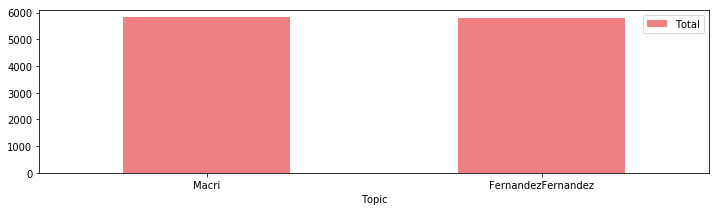

In [7]:
# Number of tweet per candidate

df_macri_serie = df_mm_total_2.groupby(['topic']).size()
df_macri = df_macri_serie.to_frame().reset_index()
df_macri.columns = ['Topic','Total']

df_fernandez_serie = df_ff_total_2.groupby(['topic']).size()
df_fernandez = df_fernandez_serie.to_frame().reset_index()
df_fernandez.columns = ['Topic','Total']

df_plot_total = df_macri.append(df_fernandez, ignore_index=True)

df_plot_total.plot(kind='bar',x='Topic',y=['Total'],color=['lightcoral'], figsize=(12,3),rot=0)



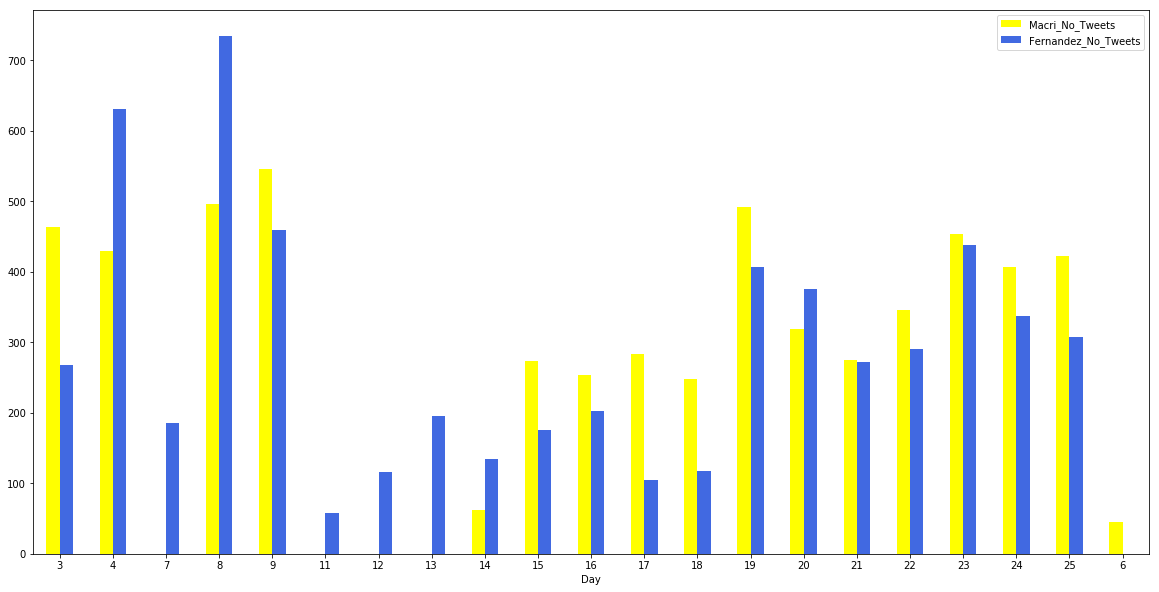

In [9]:
#Number of tweets per candidate by day

import matplotlib.pyplot as plt

mm_tt_serie = df_mm_total_2.groupby(['day']).size()
df_mm_tt = mm_tt_serie.to_frame().reset_index()
df_mm_tt.columns = ['Day','Macri_No_Tweets']


ff_tt_serie = df_ff_total_2.groupby('day').size()
df_ff_tt = ff_tt_serie.to_frame().reset_index()
df_ff_tt.columns = ['Day','Fernandez_No_Tweets']

df_to_plot = df_ff_tt.merge(df_mm_tt, on='Day', how='outer')

df_to_plot['Fernandez_No_Tweets'].fillna(0, inplace=True)
df_to_plot['Macri_No_Tweets'].fillna(0, inplace=True)
    
df_to_plot.plot(kind='bar',x='Day',y=['Macri_No_Tweets','Fernandez_No_Tweets'],color=['yellow','royalblue'], figsize=(20,10),rot=0)


In [12]:
#generate mask with the Argentinian map

import numpy as np
from PIL import Image
map_mask = np.array(Image.open("mapa4.png"))
#map_mask #(all values must be 255)


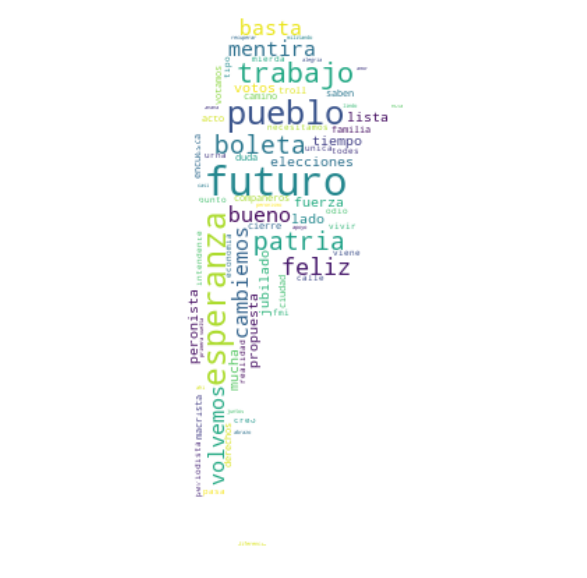

In [16]:
#make the wordcloud for FernandezFernandez usgin the mask

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(review for review in df_ff_total_2['clean_tweet'].apply(str))
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=150, mask=map_mask,
               stopwords=stop, contour_width=5, contour_color='white')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("mapa4.jpg")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

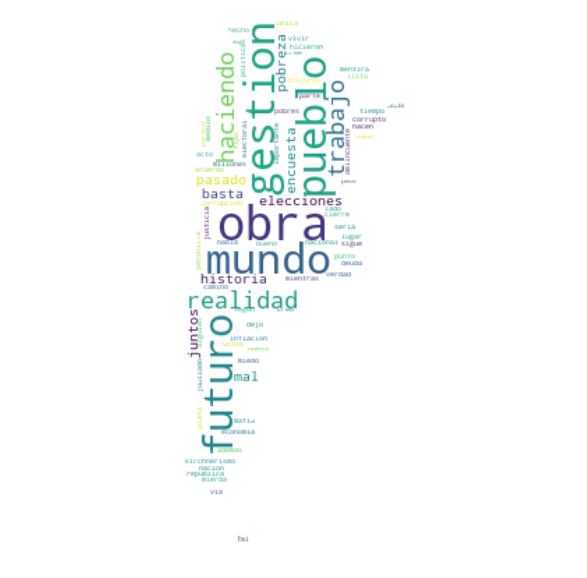

In [18]:
#make the wordcloud for Macri usgin the mask

#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(review for review in df_mm_total_2['clean_tweet'].apply(str))
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=150, mask=map_mask,
               stopwords=stop, contour_width=5, contour_color='white')

# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("mapa4.jpg")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Using cross validation gridSearch with a Random Forest Classifier

http://blog.manugarri.com/sentiment-analysis-in-spanish/

In [ ]:
import nltk
nltk.download()

In [469]:

#Tienes que descargarte las stopwords primero via nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer


spanish_stopwords = stopwords.words('spanish')

stemmer = SnowballStemmer('spanish')

non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))

stemmer = SnowballStemmer('spanish')
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = stop) #spanish_stopwords)

# Using: RandomForestClassifier

In [36]:
#Import "sentimiento" dataframe with tweets already classified between Positive (1) and Negative (0)

sentimiento = pd.read_csv(r'base_sentimiento.csv', encoding='latin-1')

#clean the tweets
sentimiento['clean_text'] = sentimiento['TEXT'].apply(lambda x: strip_all_entities(strip_links(x)))
sentimiento['clean_text'] = sentimiento['TEXT'].apply(lambda x: clean_text(str(x)))
sentimiento.head(3)

TWEET_ID      SCREEN_NAME  CREATED_AT  \
0  1126274568795115520      GaitaHernan  08/05/2019   
1  1126269140854018049  robertopozzi851  08/05/2019   
2  1126266479308156934   JuanCa61395430  08/05/2019   

                                            TEXT  Favorited  Favorite Count  \
0      @mauriciomacri Estado laico mis poliainas          0               0   
1            @mauriciomacri Gracias presidente!!          0               0   
2  @mauriciomacri Vamos carajooo!! Si se puede!!          0               0   

   Retweeted  RETWEET_COUNT OBJETO_BUSCADO  TEXTO_BUSCADO  POSITIVO  NEGATIVO  \
0          0              0             to  mauriciomacri         0         1   
1          0              0             to  mauriciomacri         1         0   
2          0              0             to  mauriciomacri         1         0   

                   clean_text  
0  estado laico mis poliainas  
1          gracias presidente  
2  vamos carajooo si se puede

In [37]:
clean = lambda x: clean_text(str(strip_all_entities(strip_links(x))))
sentimiento_clean = pd.DataFrame(sentimiento.TEXT.apply(clean))
neg_column = sentimiento[['NEGATIVO']]

sentimiento_clean = pd.concat([sentimiento_clean, neg_column], axis=1)
sentimiento_clean.head()

#column TEXT contains empty strings like: "". Remove them:
sentimiento_clean = sentimiento_clean[sentimiento_clean['TEXT']!='']
sentimiento_clean.head(3)

TEXT  NEGATIVO
0  estado laico mis poliainas         1
1          gracias presidente         0
2  vamos carajooo si se puede         0

In [38]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(sentimiento_clean, test_size=0.20, random_state=1234)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

vectorizer = CountVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = stop)#spanish_stopwords)

pipeline = Pipeline([  
    ('vect', vectorizer),
    ('randomForest', RandomForestClassifier()),
])

# here we define the parameter space to iterate through
parameters = {  
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),                
    'randomForest__n_estimators': [100, 200, 500, 1000],  
    'randomForestB __max_features': [0.5, 0.8, None,'sqrt'],
    'randomForest__max_depth': [5, 10, 15, None],        
    'randomForest__criterion': ['gini', 'entropy']
}

grid_search_rfc = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='roc_auc')  

grid_search_rfc.fit(train['TEXT'], train['NEGATIVO'])  


In [215]:
grid_search_rfc.cv_results_

{'mean_fit_time': array([ 8.98013941,  9.26438967,  8.94302432, ..., 36.6132803 ,
        30.87737147, 29.09920732]),
 'std_fit_time': array([0.04892461, 0.06778245, 0.04351317, ..., 0.26284266, 0.32382445,
        0.93060437]),
 'mean_score_time': array([4.18189859, 4.27191861, 4.21859066, ..., 5.81039   , 5.35087434,
        3.26575454]),
 'std_score_time': array([0.01631556, 0.03021012, 0.03666696, ..., 0.19426239, 0.05532293,
        0.6482884 ]),
 'param_randomForest__criterion': masked_array(data=['gini', 'gini', 'gini', ..., 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomForest__max_depth': masked_array(data=[5, 5, 5, ..., None, None, None],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_randomForest__max_features': masked_array(data=[0.5, 0.5, 0.5, ..., 'sqrt'

In [218]:
import pandas as pd
pd.DataFrame.from_dict(grid_search_rfc.cv_results_).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.980139      0.048925         4.181899        0.016316   
1       9.264390      0.067782         4.271919        0.030210   
2       8.943024      0.043513         4.218591        0.036667   
3       9.234895      0.049877         4.309208        0.043136   
4       9.177694      0.150632         6.152835        0.102034   

  param_randomForest__criterion param_randomForest__max_depth  \
0                          gini                             5   
1                          gini                             5   
2                          gini                             5   
3                          gini                             5   
4                          gini                             5   

  param_randomForest__max_features param_randomForest__n_estimators  \
0                              0.5                              100   
1                              0.5                              100   
2                              0.5                              100   
3                              0.5                              100   
4                              0.5                              100   

  param_vect__max_df param_vect__max_features param_vect__min_df  \
0                0.5                      500                 10   
1                0.5                      500                 10   
2                0.5                      500                 20   
3                0.5                      500                 20   
4                0.5                      500                 50   

  param_vect__ngram_range                                             params  \
0                  (1, 1)  {'randomForest__criterion': 'gini', 'randomFor...   
1                  (1, 2)  {'randomForest__criterion': 'gini', 'randomFor...   
2                  (1, 1)  {'randomForest__criterion': 'gini', 'randomFor...   
3                  (1, 2)  {'randomForest__criterion': 'gini', 'randomFor...   
4                  (1, 1)  {'randomForest__criterion': 'gini', 'randomFor...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.680087           0.691383           0.676684         0.682717   
1           0.693866           0.696716           0.691437         0.694006   
2           0.681404           0.695939           0.686570         0.687969   
3           0.696104           0.700921           0.680006         0.692344   
4           0.689806           0.700728           0.681903         0.690812   

   std_test_score  rank_test_score  
0        0.006282             3013  
1        0.002157             2899  
2        0.006016             2976  
3        0.008942             2930  
4        0.007717             2951

In [220]:
pd.DataFrame.from_dict(grid_search_rfc.cv_results_).mean_test_score.head(10)

0    0.682717
1    0.694006
2    0.687969
3    0.692344
4    0.690812
5    0.689481
6    0.688127
7    0.691770
8    0.688438
9    0.691153
Name: mean_test_score, dtype: float64

In [223]:
grid_search_rfc.best_score_

0.7998540927344511

In [222]:
grid_search_rfc.scorer_

make_scorer(roc_auc_score, needs_threshold=True)

In [224]:
grid_search_rfc.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=1000, min_df=10,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no'...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                           

In [225]:
grid_search_rfc.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': None,
 'randomForest__max_features': 'sqrt',
 'randomForest__n_estimators': 1000,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 10,
 'vect__ngram_range': (1, 1)}

In [79]:
# Remove strings like ' ' in train dataframe

train = train[train['TEXT']!=' ']


In [84]:
# Run a RandomForestClassifier with the best parameters shown above

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Build a Pipeline object
pipeline = Pipeline([('vect', CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    stop_words = stop,
    min_df = 10,
    max_df = 0.5,
    ngram_range=(1, 1),
    max_features=1000)),
                     
('randomForest', RandomForestClassifier(
    criterion='entropy',
    max_depth=None, 
    max_features='sqrt',
    n_estimators=1000,
)),
])

# Fit the pipeline 
pipeline.fit(train['TEXT'], train['NEGATIVO'])   

test['predicted'] = pipeline.predict(test['TEXT'])



/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ahor', 'albert', 'algun', 'amig', 'argentin', 'axelgobern', 'bolsonar', 'cad', 'campan', 'candidat', 'car', 'com', 'companer', 'contr', 'cordob', 'cos', 'cristin', 'cuand', 'desd', 'despu', 'dic', 'dij', 'dond', 'durant', 'eram', 'espos', 'estab', 'estais', 'estam', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'formul', 'frent', 'frentedetod', 'fuer', 'fues', 'fuim', 'fuist', 'gent', 'gobiern', 'graci', 'hab', 'habr', 'habran', 'habras', 'hac', 'hast', 'hem', 'hub', 'junt', 'maurici', 'medi', 'mia', 'mias', 'mio', 'mios', 'mir', 'mism', 'much', 'nad', 'nosotr', 'nuestr', 'nunc', 'octubr', 'par', 'pas', 'per', 'pichett', 'poc', 'pod', 'polit', 'porqu', 'president', 'pued', 'quer', 'qui', 'quier', 'seais', 'seam', 'segu', 'sent', 'seran', 'seras', 'siempr', 'si

In [86]:
# Model Metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import numpy as np

print("\n\t--------- RandomForestClassifier Metrics ---------")
print('\nPrecision:' ,round(precision_score(test.NEGATIVO, test.predicted),2))
print('Recall:' ,round(recall_score(test.NEGATIVO, test.predicted),2))
print('Accuracy:' ,round(accuracy_score(test.NEGATIVO, test.predicted),2))
print('Mean: ', round(np.mean(test.predicted == test.NEGATIVO),2))

print('\nConfusion Matrix: \n\n', pd.DataFrame(confusion_matrix(test.NEGATIVO, test.predicted)))




	--------- RandomForestClassifier Metrics ---------

Precision: 0.8
Recall: 0.78
Accuracy: 0.75
Mean:  0.75

Confusion Matrix: 

      0    1
0  521  219
1  242  851


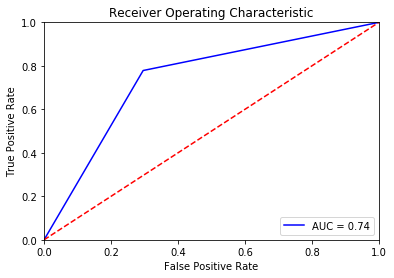

In [291]:
### ROC Curve

import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(test.NEGATIVO, test.predicted)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Using Random Forest Classifier to predict a new set of tweets

Notes:
* df_mm_total + df_mm = df_mm_total_2
* df_ff_total + df_ff = df_ff_total_2

In [90]:
# Check if macri or fernandez dataframe have any NaN value on clean_tweet column 

print("There is " + str(df_mm_total['clean_tweet'].isnull().sum()) + " NaN value in: df_mm_total[clean_tweets]")
print("There is " + str(df_ff_total['clean_tweet'].isnull().sum()) + " NaN value in: df_ff_total[clean_tweets]")


There is 1 NaN value in: df_mm_total[clean_tweets]
There is 0 NaN value in: df_ff_total[clean_tweets]


In [91]:
# Remove NaN from dataframes

df_mm_total = df_mm_total.dropna(subset=['clean_tweet'])
df_ff_total = df_ff_total.dropna(subset=['clean_tweet'])

In [92]:
# After removing the nan

print("There is " + str(df_mm_total['clean_tweet'].isnull().sum()) + " NaN value in: df_mm_total[clean_tweets]")
print("There is " + str(df_ff_total['clean_tweet'].isnull().sum()) + " NaN value in: df_ff_total[clean_tweets]")


There is 0 NaN value in: df_mm_total[clean_tweets]
There is 0 NaN value in: df_ff_total[clean_tweets]


In [243]:
# Check if additional dataframes for Macri and Fernandez have any NaN value on column clean_tweet

print("There is " + str(df_mm['clean_tweet'].isnull().sum()) + " NaN value in: df_mm[clean_tweets]")
print("There is " + str(df_ff['clean_tweet'].isnull().sum()) + " NaN value in: df_ff[clean_tweets]")

print('')
print((df_mm['clean_tweet']=='').any())
print((df_mm['clean_tweet']==' ').any())
print((df_ff['clean_tweet']=='').any())
print((df_ff['clean_tweet']==' ').any())


There is 0 NaN value in: df_mm[clean_tweets]
There is 0 NaN value in: df_ff[clean_tweets]

False
False
False
False


In [93]:
# Make prediction for Macri and Fernandez dataframes

df_mm_total['predicted'] = pipeline.predict(df_mm_total['clean_tweet'])
df_ff_total['predicted'] = pipeline.predict(df_ff_total['clean_tweet'])


In [246]:
# Add more tweets to the main dataframe for each candidate.

df_mm['predicted'] = pipeline.predict(df_mm['clean_tweet'])
df_ff['predicted'] = pipeline.predict(df_ff['clean_tweet'])


In [250]:
# Add the new set of tweets to the main dataframe

df_mm_total_2 = df_mm_total.append(df_mm, ignore_index=True)
df_ff_total_2 = df_ff_total.append(df_ff, ignore_index=True)


In [252]:
# Remove dulplicates after merging the dataframes

df_mm_total_2 = df_mm_total_2.drop_duplicates(subset = "clean_tweet", keep = "last")
df_ff_total_2 = df_ff_total_2.drop_duplicates(subset = "clean_tweet", keep = "last")



In [5]:
# Both dataframes are balanced. Only 6 tweets of difference

print(df_mm_total_2.shape)
print(df_ff_total_2.shape)


(5814, 17)
(5808, 17)


In [254]:
# Save dataframe for future use.

df_mm_total_2.to_csv(r'df_mm_total_2.csv', index=False)
df_ff_total_2.to_csv(r'df_ff_total_2.csv', index=False)


In [5]:
# Load final dataframes

df_mm_total_2 = pd.read_csv(r'df_mm_total_2.csv',index_col=False)
df_ff_total_2 = pd.read_csv(r'df_ff_total_2.csv',index_col=False)


# Stats for the candidates dataframes

In [156]:
# Stats for each candidate. Using the full dataframes: df_mm_total_2 and df_ff_total_2

macri_total_num_tweets = df_mm_total_2.shape[0]
fernandez_total_num_tweets = df_ff_total_2.shape[0]

macri_negative_tweets = df_mm_total_2[df_mm_total_2['predicted']==1].shape[0]
macri_positive_tweets = df_mm_total_2[df_mm_total_2['predicted']==0].shape[0]

fernandez_negative_tweets = df_ff_total_2[df_ff_total_2['predicted']==1].shape[0]
fernandez_positive_tweets = df_ff_total_2[df_ff_total_2['predicted']==0].shape[0]

print('\n\n\t---------- #Macri----------\n')
print('Total tweets:', macri_total_num_tweets )
print('\n(+) Positive tweets:', macri_positive_tweets)
print('(-) Negative tweets:', macri_negative_tweets)
print('\nRatio:')
print('\tNegative ratio:', round(macri_negative_tweets/macri_total_num_tweets,2))
print('\tPositive ratio:',round(macri_positive_tweets/macri_total_num_tweets,2))
print('\n On average ' + format(round(macri_negative_tweets/macri_total_num_tweets,1)*10)+' tweets out of 10 are negative')

print('\n\n\t---------- #Fernandez----------\n')
print('Total tweets:', fernandez_total_num_tweets )
print('\n(+) Positive tweets:', fernandez_positive_tweets)
print('(-) Negative tweets:', fernandez_negative_tweets)
print('\nRatio:')
print('\tNegative ratio:', round(fernandez_negative_tweets/fernandez_total_num_tweets,2))
print('\tPositive ratio:', round(fernandez_positive_tweets/fernandez_total_num_tweets,2))
print('\n On average ' + format(round(fernandez_negative_tweets/fernandez_total_num_tweets,1)*10)+' tweets out of 10 are negative')




	---------- #Macri----------

Total tweets: 5814

(+) Positive tweets: 2545
(-) Negative tweets: 3269

Ratio:
	Negative ratio: 0.56
	Positive ratio: 0.44

 On average 6.0 tweets out of 10 are negative


	---------- #Fernandez----------

Total tweets: 5808

(+) Positive tweets: 3237
(-) Negative tweets: 2571

Ratio:
	Negative ratio: 0.44
	Positive ratio: 0.56

 On average 4.0 tweets out of 10 are negative


<BarContainer object of 2 artists>

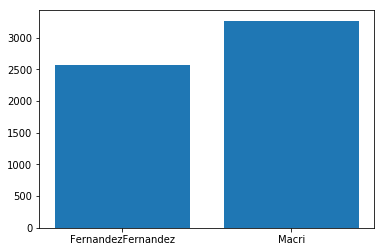

In [158]:
df_total_both = df_mm_total_2.append(df_ff_total_2, ignore_index=True)

g1 = df_total_both[df_total_both['predicted']==1].groupby( ['topic',"predicted"] ).size().reset_index(name='total')

x= g1['topic']
y=g1['total']

plt.bar(x, y)


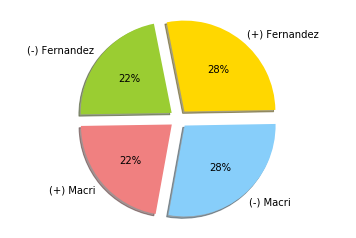

In [159]:
import matplotlib.pyplot as plt

# Data to plot
labels = '(+) Fernandez','(-) Fernandez','(+) Macri','(-) Macri'
sizes = df_total_both.groupby(['topic','predicted']).size().reset_index(name='total')['total']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0.1, 0.1, 0.1)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%', shadow=True, startangle=1)

plt.axis('equal')
plt.show()

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

macri_values = df_mm_total_2.groupby(['topic','predicted']).size().reset_index(name='total')['total']
fernandez_values = df_ff_total_2.groupby(['topic','predicted']).size().reset_index(name='total')['total']

labels = ["Positive", "Negative"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=macri_values, name="Macri"),1, 1)
fig.add_trace(go.Pie(labels=labels, values=fernandez_values, name="Fernandez"),1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.6, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="% by Candidate",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='#Macri', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='#Fernandez', x=0.87, y=0.5, font_size=20, showarrow=False)])
fig.show()

# Alternative: Analysis using NLTK Vader SentimentAnalyser
source: https://opensourceforu.com/2016/12/analysing-sentiments-nltk/


In [180]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#tweets = df_mm_total_2['clean_tweet']
sid = SentimentIntensityAnalyzer()

df_mm_total_nltk = df_mm_total_2.copy()
df_mm_total_nltk['clean_tweet'] = df_mm_total_nltk['clean_tweet'].apply(lambda x: np.str_(x))
df_mm_total_nltk['polarity'] = df_mm_total_nltk['clean_tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [181]:
# Remove unused column for this alternative
df_mm_total_nltk = df_mm_total_nltk.drop(columns=['predicted'])
df_mm_total_nltk.columns

Index(['tweet_id', 'text', 'favorite_count', 'retweeted', 'retweet_count',
       'created_at', 'source', 'reply_to_status', 'reply_to_user', 'location',
       'user', 'year', 'month', 'day', 'clean_tweet', 'topic', 'polarity'],
      dtype='object')

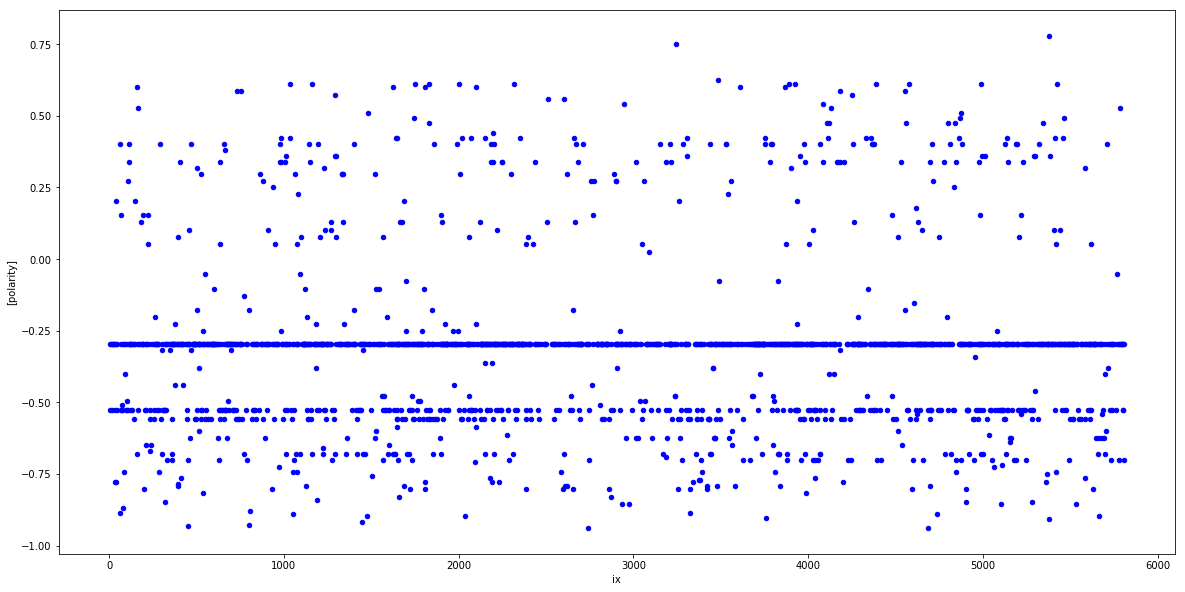

In [210]:
# To show all the polarity values
#df_mm_total.plot(kind='scatter',x='tweet_id',y=['polarity'],color=['blue'], figsize=(30,25))

# To show only the polarities diffeerent to 0
df_mm_total_nltk['ix'] = df_mm_total_nltk.index.values.astype(int)
df_mm_total_filtered = df_mm_total_nltk[df_mm_total_nltk['polarity']!=0]
df_mm_total_filtered.plot(kind='scatter',x='ix',y=['polarity'],color=['blue'], figsize=(20,10))#30,25


In [201]:
df_mm_total_filtered.index.values.astype(int)

array([   0,    1,    2, ..., 5811, 5812, 5813])

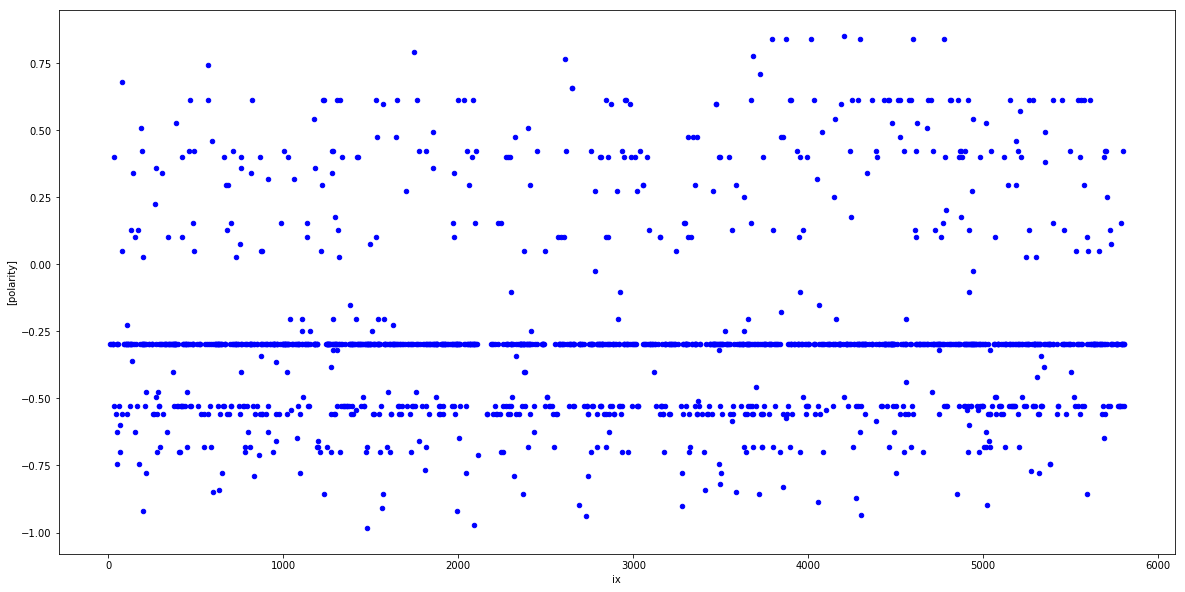

In [211]:

sid = SentimentIntensityAnalyzer()   

df_ff_total_nltk = df_ff_total_2.copy()
df_ff_total_nltk['clean_tweet'] = df_ff_total_nltk['clean_tweet'].apply(lambda x: np.str_(x))
df_ff_total_nltk['polarity'] = df_ff_total_nltk['clean_tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Remove unused column for this alternative
df_ff_total_nltk = df_ff_total_nltk.drop(columns=['predicted'])
df_ff_total_nltk.columns

df_ff_total_nltk['ix'] = df_ff_total_nltk.index.values.astype(int)
df_ff_total_filtered = df_ff_total_nltk[df_ff_total_nltk['polarity']!=0]
df_ff_total_filtered.plot(kind='scatter',x='ix',y=['polarity'],color=['blue'], figsize=(20,10))#30,25



In [215]:

def label_type (row):
    if row['polarity'] >= 0.01 :
        return 'Positive'
    if row['polarity'] <= -0.01 :
        return 'Negative'
    return 'Neutral'


df_mm_total_nltk['type'] = df_mm_total_nltk.apply(lambda x: label_type(x), axis=1)
df_ff_total_nltk['type'] = df_ff_total_nltk.apply(lambda x: label_type(x), axis=1)

print('Macri sentiment rate: ', df_mm_total_nltk.groupby('type').size())
print('')
print('Fernandez sentiment rate: ',df_ff_total_nltk.groupby('type').size())




Macri sentiment rate:  type
Negative    1617
Neutral     3969
Positive     228
dtype: int64

Fernandez sentiment rate:  type
Negative    1371
Neutral     4173
Positive     264
dtype: int64


In [50]:
print('Macri')
print('\tPositive tweets:')
print('\t\tTweets fav: ', df_mm_total_2[df_mm_total_2['predicted']==1]['favorite_count'].sum())
print('\t\tRetweet count: ', df_mm_total_2[df_mm_total_2['predicted']==1]['retweet_count'].sum())

print('\n\tNegative tweets:')
print('\t\tTweets fav:', df_mm_total_2[df_mm_total_2['predicted']==0]['favorite_count'].sum())
print('\t\tRetweet count: ', df_mm_total_2[df_mm_total_2['predicted']==0]['retweet_count'].sum())

print('Fernandez')
print('\tPositive tweets:')
print('\t\tTweets fav: ', df_ff_total_2[df_ff_total_2['predicted']==1]['favorite_count'].sum())
print('\t\tRetweet count: ', df_ff_total_2[df_ff_total_2['predicted']==1]['retweet_count'].sum())

print('\n\tNegative tweets:')
print('\t\tTweets fav:', df_ff_total_2[df_ff_total_2['predicted']==0]['favorite_count'].sum())
print('\t\tRetweet count: ', df_ff_total_2[df_ff_total_2['predicted']==0]['retweet_count'].sum())


Macri
	Positive tweets:
		Tweets fav:  24903
		Retweet count:  36005

	Negative tweets:
		Tweets fav: 17117
		Retweet count:  13723
Fernandez
	Positive tweets:
		Tweets fav:  17529
		Retweet count:  10376

	Negative tweets:
		Tweets fav: 17336
		Retweet count:  13752


In [10]:
#Combine dataframes
df_total_both = df_mm_total_2.append(df_ff_total_2, ignore_index=True)


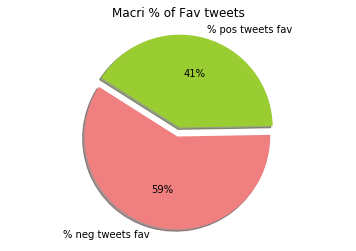

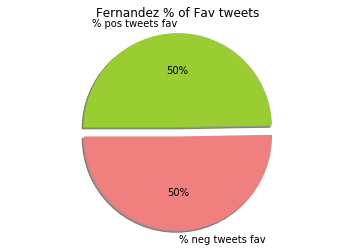

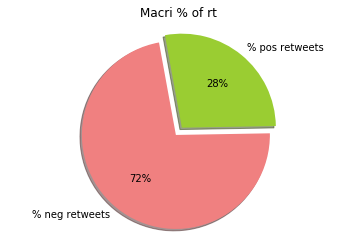

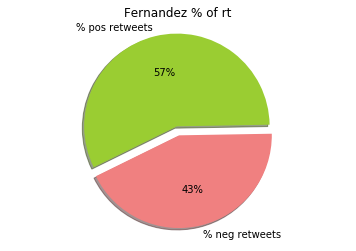

In [35]:
# Plot % of fav and rt. Pos vs Neg

df_aux = df_total_both.groupby(['topic','predicted'])[['favorite_count','retweet_count']].sum().reset_index()
labels_fav = '% pos tweets fav','% neg tweets fav'
labels_rt = '% pos retweets','% neg retweets'

colors = ['yellowgreen', 'lightcoral']
explode = (0.1, 0)

sizes_m = df_aux[df_aux['topic']=='Macri']['favorite_count']
plt.pie(sizes_m, explode=explode, labels=labels_fav, colors=colors, autopct='%1.0f%%', shadow=True, startangle=1)
plt.axis('equal')
plt.title("Macri % of Fav tweets")#, bbox={'facecolor':'0.8', 'pad':5})
plt.show()
print('\r')

sizes_f = df_aux[df_aux['topic']=='FernandezFernandez']['favorite_count']
plt.pie(sizes_f, explode=explode, labels=labels_fav, colors=colors, autopct='%1.0f%%', shadow=True, startangle=1)
plt.axis('equal')
plt.title("Fernandez % of Fav tweets")#, bbox={'facecolor':'0.9', 'pad':0.5})
plt.show()
print('\r')


sizes_f = df_aux[df_aux['topic']=='Macri']['retweet_count']
plt.pie(sizes_f, explode=explode, labels=labels_rt, colors=colors, autopct='%1.0f%%', shadow=True, startangle=1)
plt.axis('equal')
plt.title("Macri % of rt")#, bbox={'facecolor':'0.8', 'pad':0.5})
plt.show()
print('\r')


sizes_f = df_aux[df_aux['topic']=='FernandezFernandez']['retweet_count']
plt.pie(sizes_f, explode=explode, labels=labels_rt, colors=colors, autopct='%1.0f%%', shadow=True, startangle=1)
plt.axis('equal')
plt.title("Fernandez % of rt")#, bbox={'facecolor':'0.8', 'pad':0.5})
plt.show()
print('\r')



# Tweets Geo-distribution

In [ ]:
# parse the tweet and load it into a panda's dataframe
def parse_tweet(tweet_object):
    
    # create empty list
    tweet_list =[]
    
    # loop through tweet objects
    for tweet in tweet_object:
        if (tweet.coordinates is not None):
            tweet_id = tweet.id # unique integer identifier for tweet
            coordinates = tweet.coordinates
            lon = tweet.coordinates['coordinates'][0]
            lat = tweet.coordinates['coordinates'][1]
            user = tweet.user.screen_name


            # append attributes to list
            tweet_list.append({'tweet_id':tweet_id, 
                              'coordinates':coordinates,
                              'lon': lon,
                              'lat': lat,
                              'user':user,
                              })
    # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['tweet_id',
                                           'coordinates',
                                           'lon',
                                           'lat',
                                           'user'
                                          ])
    return df

In [ ]:
# generate a dataframe for FernandezFernandez
keywords = "#FrenteDeTodos OR #AlbertoFernandez OR #FernandezFernandez2019 OR #FernandezFernandez -filter:retweets"
tweets = tweepy.Cursor(api.search, q = keywords,
                                   geocode = '-34.607318,-58.455621,2000km',
                                   since = "2019-08-10",
                                   #until = "2019-07-21",
                                   #tweet_mode='extended',
                                   #monitor_rate_limit=True, 
                                   #wait_on_rate_limit=True,
                                   #lang = 'es', 
                                   exclude_replies = True).items(10000)

df_ff = parse_tweet(tweets)

In [ ]:
#To save dataframes
df_ff.to_csv(r'fernandez_tweets_ns3.csv', index=False)

In [ ]:
# generate a dataframe for Macri
keywords = "#JuntosPorElCambio OR #Macri OR #Macri2019 OR #MacriPichetto2019 -filter:retweets"
tweets = tweepy.Cursor(api.search, q = keywords,
                                   geocode = '-34.607318,-58.455621,2000km',
                                   since = "2019-08-10",
                                   #until = "2019-07-21",
                                   #tweet_mode='extended',
                                   #monitor_rate_limit=True, 
                                   #wait_on_rate_limit=True,
                                   #lang = 'es', 
                                   exclude_replies = True).items(10000)

df_mm = parse_tweet(tweets)

In [ ]:
#To save dataframes
df_mm.to_csv(r'macri_tweets_ns3.csv', index=False)

In [11]:
#To read dataframes

df_mm = pd.read_csv(r'macri_tweets_ns3.csv',index_col=0)
df_ff = pd.read_csv(r'fernandez_tweets_ns3.csv',index_col=0)



In [12]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\nsett\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


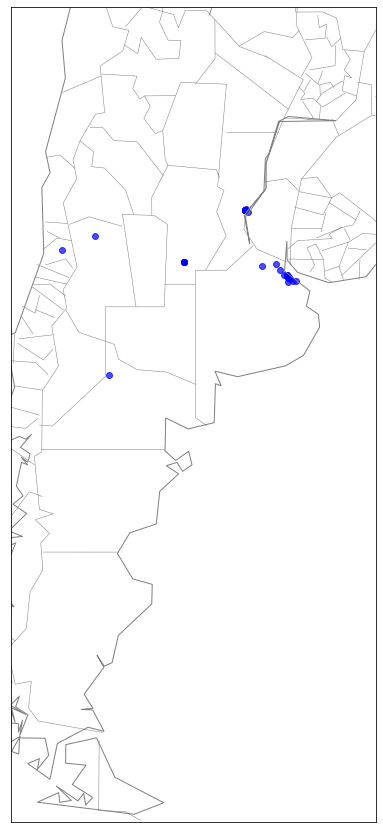

In [14]:
# Import Basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Set up the ARG bounding box
ar_boundingbox = [-73.41, -55.25, -53.62, -21.83] 

# Set up the Basemap object
m = Basemap(llcrnrlon = ar_boundingbox[0],
            llcrnrlat = ar_boundingbox[1],
            urcrnrlon = ar_boundingbox[2],
            urcrnrlat = ar_boundingbox[3],
            projection='merc')

#Because we can't plot whole bounding boxes, we summarize the bounding box location into a single point called a centroid. 
#Plotting these on a Basemap map is straightforward. Once we calculate the centroids, we separate the longitudes and latitudes, 
#then pass to the .scatter() method.

# Calculate the centroids for the dataset 
# and isolate longitudue and latitudes
import numpy as np

array_lon = np.array(df_ff.lon, dtype=pd.Series)

array_lat = np.array(df_ff.lat, dtype=pd.Series)

lon = array_lon
lat = array_lat

# Draw continents, coastlines, countries, and states
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Draw the points and show the plot
m.scatter(lon, lat, color='b', latlon = True, alpha = 0.7, label='Fernandez')
plt.rcParams['figure.figsize'] = [30,15]
plt.show()



C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


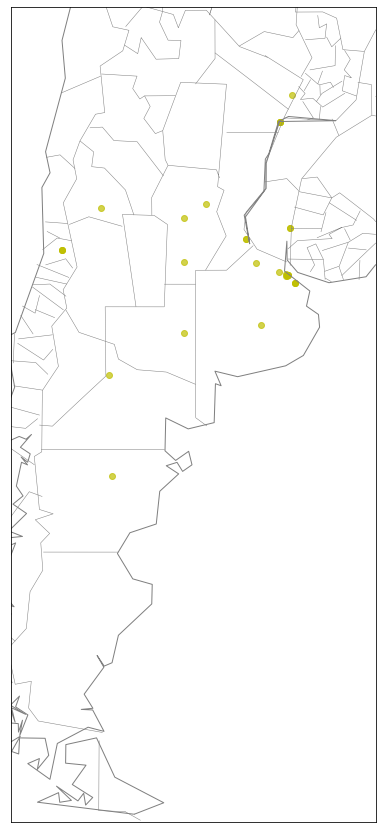

In [15]:
# Set up the ARG bounding box
ar_boundingbox = [-73.41, -55.25, -53.62, -21.83] 

# Set up the Basemap object
m = Basemap(llcrnrlon = ar_boundingbox[0],
            llcrnrlat = ar_boundingbox[1],
            urcrnrlon = ar_boundingbox[2],
            urcrnrlat = ar_boundingbox[3],
            projection='merc')


array_lon_mm = np.array(df_mm.lon, dtype=pd.Series)

array_lat_mm = np.array(df_mm.lat, dtype=pd.Series)

lon = array_lon_mm
lat = array_lat_mm

# Draw continents, coastlines, countries, and states
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Draw the points and show the plot
m.scatter(lon, lat, color='y', latlon = True, alpha = 0.7)
plt.show()

C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\nsett\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


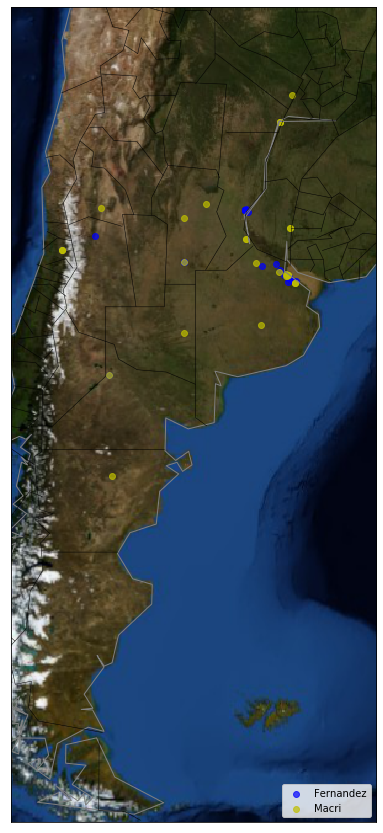

In [16]:
# Import Basemap
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Set up the ARG bounding box
ar_boundingbox = [-73.41, -55.25, -53.62, -21.83] 

# Set up the Basemap object
m = Basemap(llcrnrlon = ar_boundingbox[0],
            llcrnrlat = ar_boundingbox[1],
            urcrnrlon = ar_boundingbox[2],
            urcrnrlat = ar_boundingbox[3],
            projection='merc')

m.bluemarble()

#Because we can't plot whole bounding boxes, we summarize the bounding box location into a single point called a centroid. 
#Plotting these on a Basemap map is straightforward. Once we calculate the centroids, we separate the longitudes and latitudes, 
#then pass to the .scatter() method.

# Calculate the centroids for the dataset 
# and isolate longitudue and latitudes
import numpy as np

array_lon = np.array(df_ff.lon, dtype=pd.Series)

array_lat = np.array(df_ff.lat, dtype=pd.Series)

lon = array_lon
lat = array_lat

# Draw continents, coastlines, countries, and states
plt.rcParams['figure.figsize'] = [30,15]
m.fillcontinents(color='white', zorder = 0)
m.drawcoastlines(color='gray')
m.drawcountries(color='k')
m.drawstates(color='k')

# Draw the points and show the plot
m.scatter(lon, lat, color='b', latlon = True, alpha = 0.7, label='Fernandez')


array_lon_mm = np.array(df_mm.lon, dtype=pd.Series)

array_lat_mm = np.array(df_mm.lat, dtype=pd.Series)

lon = array_lon_mm
lat = array_lat_mm

# Draw the points and show the plot
m.scatter(lon, lat, color='y', latlon = True, alpha = 0.7, label='Macri')
plt.legend(loc='lower right')
plt.show()



# Tweeter Friends API

In [5]:
# Parse the tweet and load it into a panda's dataframe

def parse_response(tweet_object,s_name):
    
    # create empty list
    tweet_list =[]
    
    # loop through tweet objects
    for tweet in tweet_object:
            user_id = tweet.id # unique integer identifier for account
            screen_name = tweet.screen_name 
            source = s_name


            # append attributes to list
            tweet_list.append({'user_id':user_id, 
                              'screen_name':screen_name, 
                              'source':source,
                              })
    # create dataframe   
    df = pd.DataFrame(tweet_list, columns=['user_id',
                                           'screen_name',
                                           'source',
                                          ])
    return df



In [6]:
# generate a dataframe for mauriciomacri friends
tweets = tweepy.Cursor(api.friends, screen_name = 'mauriciomacri').items(10000)
s_name = 'mauriciomacri'
df_mm_friends = parse_response(tweets,s_name)

In [ ]:
#To save dataframes
df_mm_friends.to_csv(r'mm_tw_friends.csv', index=False)

In [19]:
#To read dataframes
df_mm_friends = pd.read_csv(r'mm_tw_friends.csv', index_col=0)

In [8]:
# generate a dataframe for mauriciomacri friends
tweets = tweepy.Cursor(api.friends, screen_name = 'alferdez').items(10000)
s_name = 'alferdez'
df_ff_friends = parse_response(tweets, s_name)

In [25]:
#To save dataframes
df_ff_friends.to_csv(r'ff_tw_friends.csv', index=False)

In [26]:
#To read dataframes
df_ff_friends = pd.read_csv(r'ff_tw_friends.csv', index_col=0)

# Common tweeter friends between Macri and Fernandez

In [19]:
#inner join in python pandas
df_common_friends = pd.merge(df_ff_friends, df_mm_friends, on='user_id', how='inner')

In [60]:
# list of common friends for Macri and Fernandez
df_common_friends[['screen_name_x']]

screen_name_x
user_id                   
143852870     jmcapitanich
172064501    MatiasLammens
77009449   horaciorlarreta
525264466      Pontifex_es
83766099           mnachon
180990597   juancampanella
7827962     InfobaeAmerica
176540641  canal26noticias
69668594   LupeTagliaferri
789856765    cuervotinelli
91361327        radiolared
145087962   JaimeRosemberg
731430768  CarlosMelconian
170955445   agencialavieja
87741293       rlorenzetti
171468523   nelsonalcastro
196447332    lozano_manuel
95970921     pabloavelluto
166022063      SanzErnesto
271129391       GuilleLobo
16492551        fedesturze
80396134         halconada
114510872         JPVarsky
500317946   fantinofantino
181408748  maximmontenegro
135675218    luisnovaresio
51714340     PRossiOficial
77207659    andykusnetzoff
16294264         perfilcom
35778170      gabimichetti
36787113       PaulaBertol
259681081  AntonioBonfatti
163088565     omoscariello
124779370        rialjorge
45136035       EquipoBulat
182923335       radiomitre
142684449        majulluis
25992212      todonoticias
33989170          LANACION
31133330      danielscioli

In [61]:
print('Number of common friends:', len(df_common_friends['screen_name_x']))

Number of common friends: 40


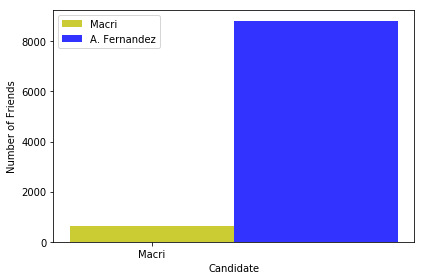

In [49]:
# Twitter number of friends comparison

import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 1
friends_mm = len(df_mm_friends)
friends_ff = len(df_ff_friends)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, friends_mm, bar_width,
alpha=opacity,
color='y',
label='Macri')

rects2 = plt.bar(index + bar_width, friends_ff, bar_width,
alpha=opacity,
color='b',
label='A. Fernandez')

plt.xlabel('Candidate')
plt.ylabel('Number of Friends')
#plt.title('Twitter Friends Comparison')
plt.xticks(index, ('Macri', 'A. Fernandez'))
plt.legend()

plt.tight_layout()
plt.show()





In [2]:
# Load the dataframes cleaned 
import pandas as pd
df_mm_manual = pd.read_csv(r'macri_clean_tweets.csv', encoding='latin-1')
df_ff_manual = pd.read_csv(r'fernandez_clean_tweets.csv', encoding='latin-1')

In [5]:
df_mm_manual = df_mm_manual[['tweet_id', 'clean_tweet']]

In [7]:
df_mm_manual.to_csv(r'df_mm_manual.csv', sep='|', index=False)